# Предобработка данных

Задание:

Цель: Помочь категорийному менеджеру, закупающему арматуру, сэкономить.
В репозитории файлах train и test есть понедельная история рыночных цен на арматуру в промежутке 2015-2023 гг. Также в репозитории представлены дополнительные данные, которые можно использовать для прогнозирования цены. Любые другие внешние данные использовать запрещено.


Необходимо разработать модель, которая по истории цен и дополнительных данных за период [1,T] делает рекомендацию по объему тендера на арматуру для недели T. 
Рекомендация на N недель фиксирует цену на N недель, следующий тендер будет проведен на неделе T+N. Считаем, что тендеры проводятся по понедельникам, для прогноза на следующие N недель оперировать можно историческими данными до понедельника включительно.

На основе полученной модели, необходимо разработать приложение для пользователя (категорийного менеджера) с интуитивно понятным интерфейсом


In [275]:
# импорт основных библиотек для работы с датасетом и визуализациями
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [276]:
df = pd.read_excel('train.xlsx')

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


Судя по данным можно сделать позитивные выводы - пропуски в датасете отсуствуют, данные полностью заполнены.
Типы данных уже верные, так что изменять ничего не нужно.
Данные можно назвать полными и корректными, но недостаточно уточнёными. Для этого введём дополнительные признаки, которые получим из даты.

1. **Год** — может помочь в выявлении долгосрочных трендов.

2. **Месяц** — сезонные колебания.

3. **Квартал** — влияние квартальных факторов.

4. **День месяца** — возможно, влияние дня на цену.

5. **День недели** — например, цены могут меняться в определённые дни.
<!-- 
8. **Скользящее среднее** — сглаживание временного ряда.

9. **Скользящее стандартное отклонение** — волатильность цен.

10. **Признаки праздников** — если есть данные о праздниках, они могут влиять на спрос.

11. **Разница между текущей и предыдущей ценой** — изменение цены за период. -->

In [ ]:
def add_date_features(df, date_column: str):
    """
    Добавляет в датафрейм новые столбцы на основе даты: месяц, квартал, день недели, год, день месяца.
    """
    # Копируем датафрейм, чтобы не изменять исходный
    df = df.copy()

    # Добавляем новые столбцы
   
    df['year'] = df['dt'].dt.year              # Год
    df['month'] = df['dt'].dt.month            # Месяц (1-12)
    df['quarter'] = df['dt'].dt.quarter        # Квартал (1-4)
    df['day_of_week'] = df['dt'].dt.dayofweek  # День недели (0-6, 0=понедельник)
    df['day_of_month'] = df['dt'].dt.day       # День месяца

    return df

In [279]:
# df = add_date_features(df, date_column='dt')
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [280]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


для облегчения дальнейшей работы с данными выберем как индекс дату

In [281]:
df = df.set_index(['dt'])
df.sort_index(inplace=True)
df.head()

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300


# Общие графики

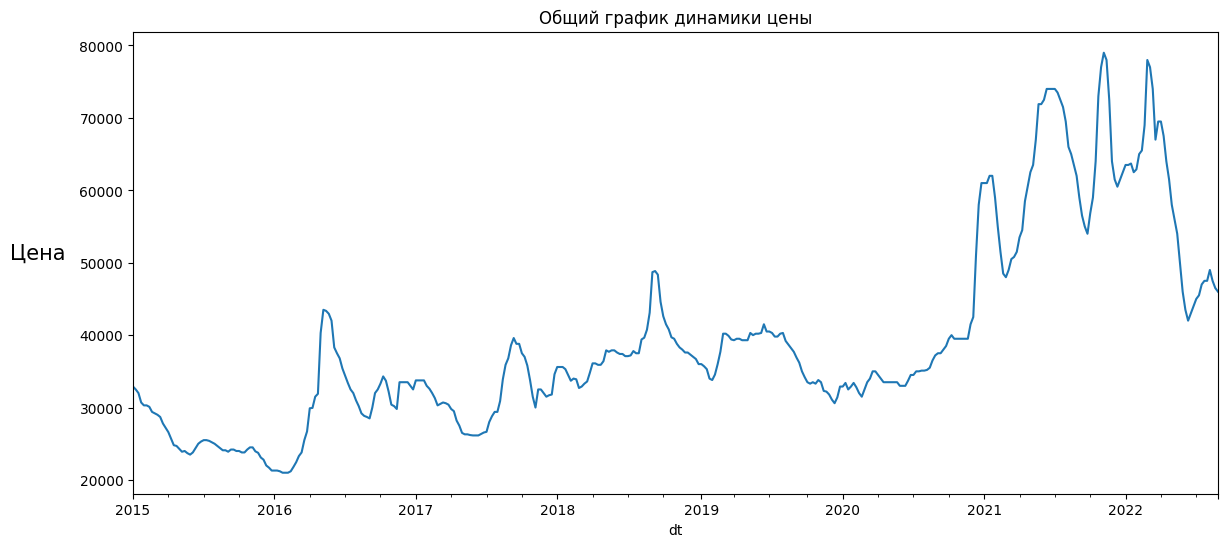

In [282]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Общий график динамики цены')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
df['Цена на арматуру'].plot();

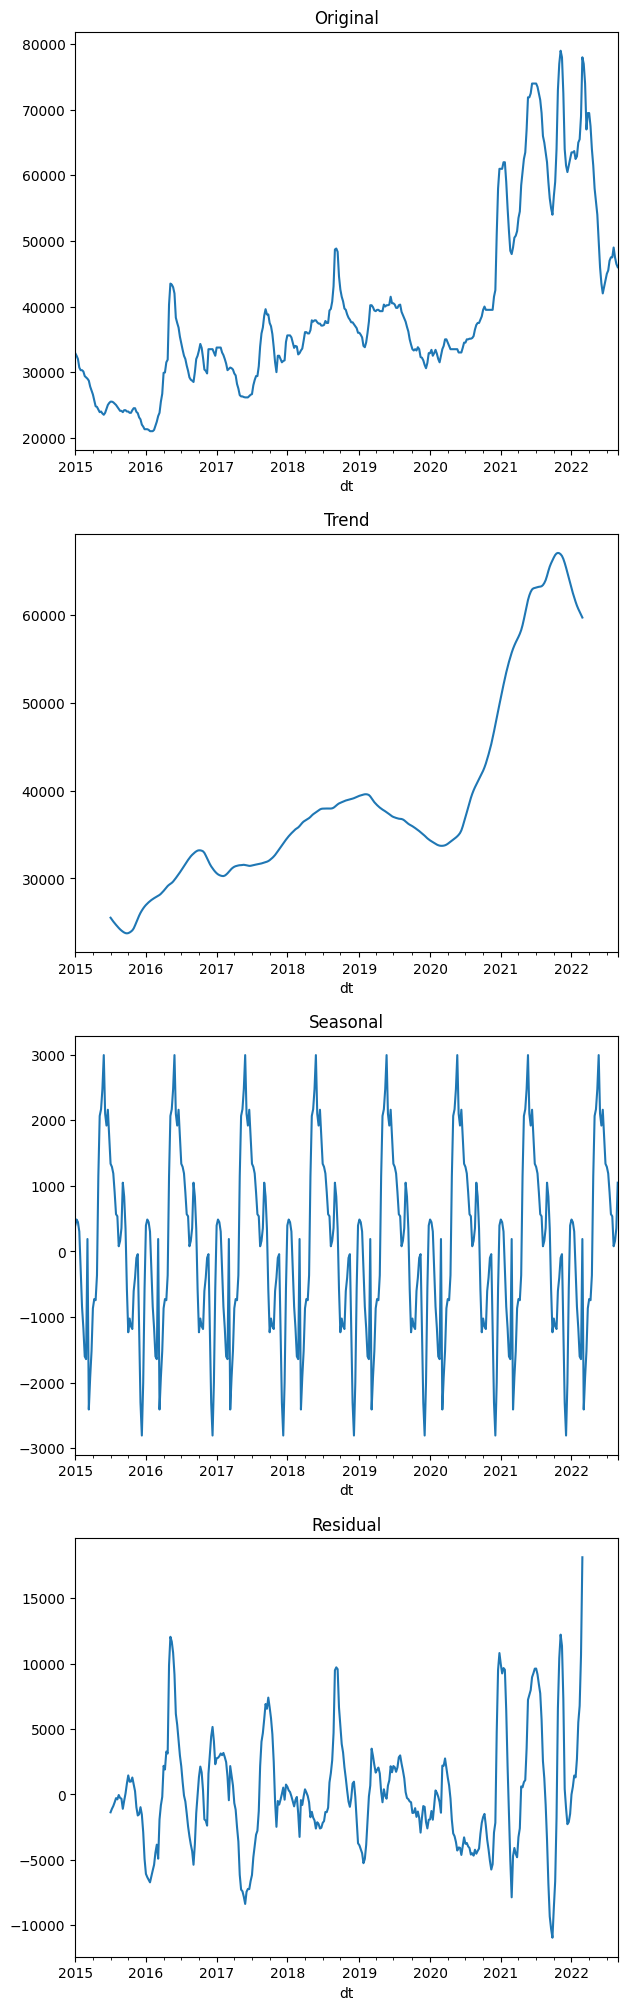

In [283]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 25))
decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

# Автокоррреляции и кареллограмма

In [284]:
# Получил 'сырые' значения автокорреляций
acf(df['Цена на арматуру'], nlags=60, fft=False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023])

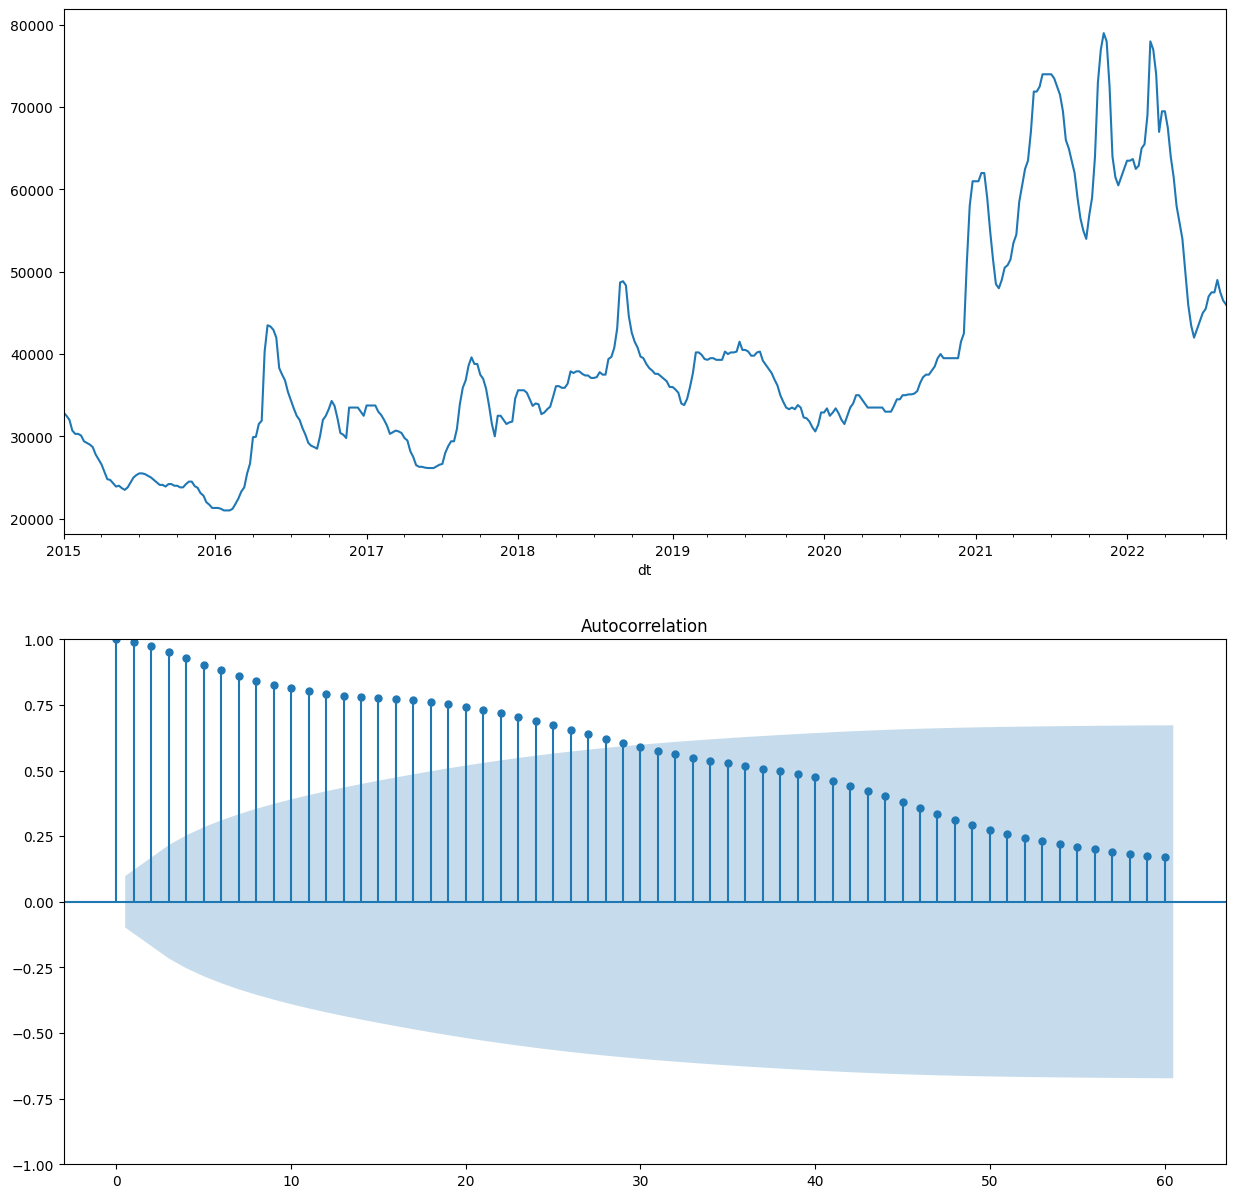

In [285]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df['Цена на арматуру'], lags=60, ax=ax[1]);

In [286]:
df.to_csv("to-modal.csv", index=True)

# Стационарность

Теперь проверим временной ряд на стационарность. По графику уже можно сказать, что он не стационарен, т.к. можно невооруженным глазом заметить сезонность - цена примерно одинаково меняется в течение одного года.
Для точности воспользуемся тестом Дики-Фуллера, который предоставляет количественную оценку стационарности временного ряда.
Основная (нулевая) гипотеза теста предполагает, что ряд динамики не стационарен. Если p_value будет меньше уровня значимости 0.05, то гипотеза отвергается и ряд может считаться стационарным.

In [287]:
def check_stationary(df):
    p_value = adfuller(df['Цена на арматуру'])[1]
    print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')
    if p_value > 0.05:
        print(f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной')
    else:
        print(f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным')

In [288]:
check_stationary(df)

Полученный уровень значимости (p-value): 0.32.
0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной


Основые способы приведения ряда к стационарности:

1. Дифференцирование: один из самых распространенных методов, именно с помощью дифференцирования ARIMA приводит ряд к стационарности. Этот процесс основывается на вычислении разницы между последовательными наблюдениями во временном ряду. 

2. Сезонное дифференцирование: вариация обычного дифференцирования, которая применяется для данных с сезонной компонентой

3. Логарифмирование: создание логарифма данных может помочь снизить вариативность ряда и сделать его более стационарным. 

## Первый способ
простое дифференцирование

In [289]:
# Например, для месячных данных с сезонностью 12 месяцев
seasonal_diff = df.diff(2).dropna()
seasonal_diff

,Цена на арматуру
dt,
2015-01-19,-900.0
2015-01-26,-1800.0
2015-02-02,-1700.0
2015-02-09,-400.0
2015-02-16,-200.0
...,...
2022-08-01,500.0
2022-08-08,1500.0
2022-08-15,0.0


In [290]:
check_stationary(seasonal_diff)

Полученный уровень значимости (p-value): 0.0.
0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным


## Второй способ
Метод бокскокса, дифференцирование

In [291]:
# from scipy.stats import boxcox
# diff_log_df = df.copy()
# diff_log_df['Цена на арматуру'] = np.log(abs(diff_log_df['Цена на арматуру']))
# diff_log_df['Цена на арматуру'], lambda_ = boxcox(diff_log_df['Цена на арматуру'])
# diff_log_df['Разница цен на арматуру'] = diff_log_df['Цена на арматуру'] - diff_log_df['Цена на арматуру'].shift(2)
# diff_log_df['Разница цен на арматуру'].dropna().plot()

# diff_log_df = diff_log_df.diff().dropna()
# diff_log_df

In [292]:
# check_stationary(df_roll)

## Третий способ
скользящая точка, логарифмирование и дифференцирование


In [293]:
window = 12  # Например, 12 для месячных данных

df_roll = df.copy()
df_roll['rolling_std'] = df_roll['Цена на арматуру'].rolling(window=window).std()

# Нормализуем данные
df_roll['normalized_price'] = df_roll['Цена на арматуру'] / df_roll['rolling_std']

# Затем логарифмируем и дифференцируем
df_roll['log_normalized_price'] = np.log(df_roll['normalized_price'] + 1e-10)  # Добавляем константу, чтобы избежать нулей
df_roll['Цена на арматуру'] = df_roll['log_normalized_price'].diff().dropna()

df_roll = df_roll.dropna()
df_roll

,Цена на арматуру,rolling_std,normalized_price,log_normalized_price
dt,,,,
2015-03-30,-0.012110,1556.413905,17.476071,2.860833
2015-04-06,-0.015806,1546.329966,17.202021,2.845027
2015-04-13,-0.071902,1605.388653,16.008585,2.773125
2015-04-20,-0.172149,1840.186914,13.476892,2.600977
2015-04-27,-0.077325,1980.109425,12.474058,2.523651
...,...,...,...,...
2022-08-01,0.271592,3320.049288,14.307017,2.660750
2022-08-08,0.330165,2461.829820,19.903894,2.990915
2022-08-15,0.097365,2165.063509,21.939310,3.088280


In [294]:
check_stationary(df_roll)

Полученный уровень значимости (p-value): 0.0.
0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным


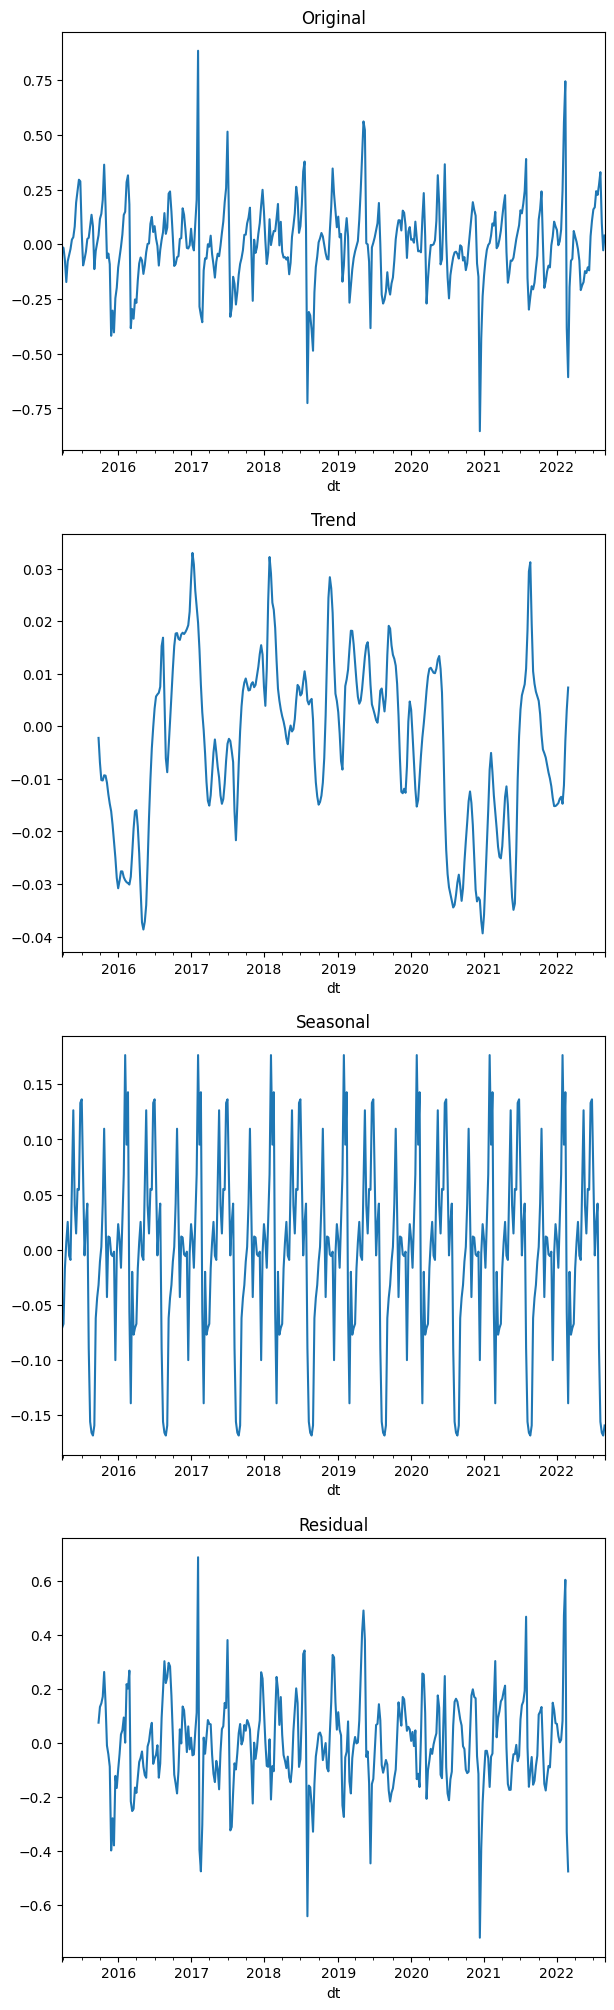

In [303]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 25))
decompose = seasonal_decompose(df_roll['Цена на арматуру']) 

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [295]:
# еще проверка на стационарность, но в другом ключе

# def kpss_test(timeseries):
#   print ('Results of KPSS Test:')
#   kpsstest = kpss(timeseries, regression='c')
#   kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
#   for key,value in kpsstest[3].items():
#   kpss_output['Critical Value (%s)'%key] = value
#   print (kpss_output)

In [297]:
df_roll.to_csv("to-modal.csv", index=True)